In [118]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons
from copy import deepcopy

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot
from collections import defaultdict
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris
from collections.abc import Mapping
from poliastro.extra_util import get_galilean_orbs, ecliptic_slingshot, get_galilean_ephemerides
#from poliastro.extra_util import get_single_burn_elliptical_hohmann
solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [119]:
start_date= time.Time("2037-06-11 00:01", scale="utc").tdb
end_date= time.Time("2037-09-21 00:01", scale="utc").tdb
epochs=time_range(start=start_date,end=end_date,periods=50)

callisto_ephem = Ephem.from_horizons(504,epochs= epochs, attractor= Jupiter,plane=Planes.EARTH_ECLIPTIC)#Callisto is 504
callisto_orb= Orbit.from_ephem(attractor=Jupiter,ephem=callisto_ephem,epoch=start_date)


r_perijove = Jupiter.R+230000 * u.km
r_apijove = Jupiter.R+6.5e6*u.km
a_start = (r_perijove+r_apijove)/2
ecc_start = (r_perijove-r_apijove)/(r_perijove+r_apijove)

starship_orb=Orbit.from_classical(
Jupiter, a_start, ecc_start, callisto_orb.inc, 
callisto_orb.raan, 0*u.deg, -10*u.deg,
start_date,plane=Planes.EARTH_ECLIPTIC)


print(starship_orb.period.to(u.day))


41.15560137426637 d


In [120]:
ephemerides = get_galilean_ephemerides(start_date, end_date)

# # Access like this:
europa_ephem = ephemerides[Europa]
io_ephem = ephemerides[Io]
ganymede_ephem = ephemerides[Ganymede]
callisto_ephem = ephemerides[Callisto]
galilean_orbs = get_galilean_orbs(start_date,start_date+10*u.day)

# Access like this:
europa_orb = galilean_orbs[Europa]
print(europa_orb)


665064 x 676992 km x 2.0 deg orbit around Jupiter (♃) at epoch 2037-06-11 00:02:09.185 (TDB)


In [121]:
europa_orb= Orbit.from_ephem(attractor=Jupiter,ephem=europa_ephem,epoch=start_date)
ganymede_orb= Orbit.from_ephem(attractor=Jupiter,ephem=ganymede_ephem,epoch=start_date)
io_orb= Orbit.from_ephem(attractor=Jupiter,ephem=io_ephem,epoch=start_date) 
callisto_orb= Orbit.from_ephem(attractor=Jupiter,ephem=callisto_ephem,epoch=start_date)

In [122]:
##Takes in target orbit, rather than generating from ephem to avoid Jovian ephem problems
def get_single_burn_elliptical_hohmann(target_orb, initial_orb, min_tof=0.1*u.day, max_tof=50*u.day, tof_step=0.1*u.day, max_revs=0):
    time_till_pe=initial_orb.period-initial_orb.t_p
    periapsis_epoch=initial_orb.epoch+time_till_pe
    # plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
    min_dv=50000*u.m/u.s
    final_orb=None
    final_date=None
    final_burn=None
    final_targ_orb=None
    periapsis_orb=initial_orb.propagate(periapsis_epoch)
    body_orb_placeholder = target_orb.propagate(periapsis_epoch)
    tof_range=np.arange(min_tof.to(u.day).value,max_tof.to(u.day).value,tof_step.to(u.day).value)*u.day
    for i in range(len(tof_range)):
        arrival_date=periapsis_epoch+tof_range[i]
        body_orb=body_orb_placeholder.propagate(arrival_date+1*u.s)
        # print(f"{initial_orb} and {body_orb}")
        for j in range(max_revs):
            try:
                lambert=Maneuver.lambert(periapsis_orb,body_orb,M=j)
                burn=lambert[0]
                dv=np.linalg.norm(burn[1])
                if dv<min_dv:
                    min_dv=dv
                    final_orb,dummy=periapsis_orb.apply_maneuver(lambert,intermediate=True)
                    final_date=arrival_date
                    final_burn=burn
                    final_targ_orb=body_orb
                    # plotter.plot(final_orb)
            except Exception as e:
                # print(e)
                continue

    return [min_dv,final_orb,final_targ_orb,final_date,final_burn,time_till_pe]

In [123]:
transfer=get_single_burn_elliptical_hohmann(
    ganymede_orb,
    starship_orb,
    tof_step=0.1*u.day,
    min_tof=10*u.day,
    max_tof=100*u.day,
    max_revs=4
)
starship_flyby_orbit=transfer[1].propagate(transfer[2].epoch)
body_flyby_orbit=transfer[2]

In [124]:
print(f"Dv is {transfer[0]}, time of flight is {(-transfer[5]+transfer[3]-starship_orb.epoch).to(u.day):.2f} from perijove")
print(f"Flyby at {body_flyby_orbit.epoch}, speed {np.linalg.norm(body_flyby_orbit.v-starship_flyby_orbit.v)}")

Dv is 26.081645872423543 m / s, time of flight is 19.70 d from perijove
Flyby at 2037-07-09 23:09:29.667, speed 12.084803962650232 km / s


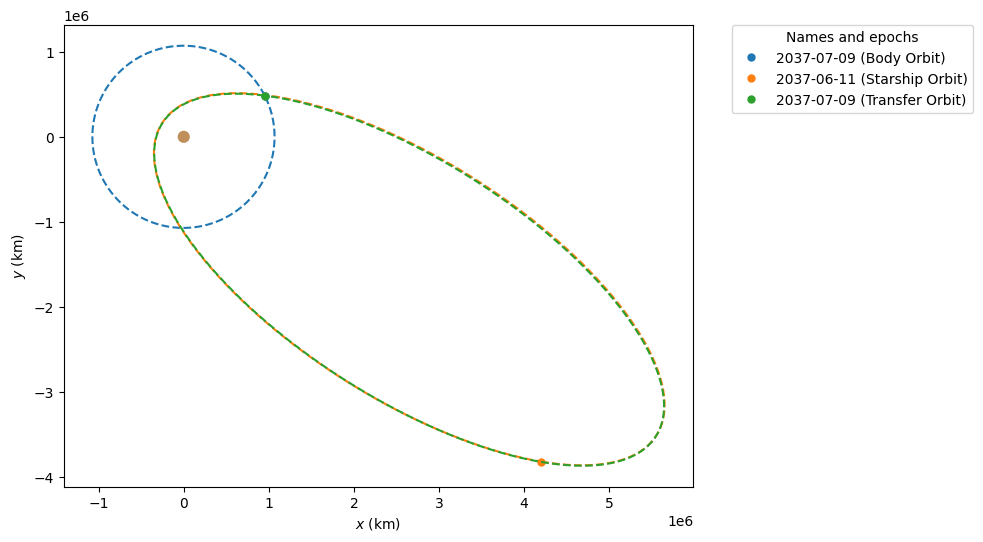

In [125]:



plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
plotter.plot(body_flyby_orbit, label="Body Orbit")
plotter.plot(starship_orb, label="Starship Orbit")
plotter.plot(starship_flyby_orbit, label="Transfer Orbit")

In [126]:
def assist_possible_periods(spacecraft_orb, body_orb, body, r_p_min=10*u.km, r_p_max=5000*u.km, num_samples=500):#finds possible periods of orbit around attractor given flyby
    periods=np.zeros((num_samples,2))
    periaps=np.zeros((num_samples))
    attractor=spacecraft_orb.attractor
    flyby_dist=np.linalg.norm(spacecraft_orb.r-body_orb.r)
    if(flyby_dist)<4*body.R:
        rel_vel=spacecraft_orb.rv()[1]-body_orb.rv()[1]
        rel_speed=np.linalg.norm(rel_vel)
        r_ps = body.R + np.linspace(r_p_min.to(u.km).value, r_p_max.to(u.km).value, num=num_samples) * u.km
        rot_angs = 2 * np.arcsin(1 / ((r_ps * rel_speed**2 / body.k) + 1 * u.one))
        # Rotation axis in ecliptic plane
        axis = np.array([0, 0, 1.0])
        axis = axis / np.linalg.norm(axis)
        # Try both rotation directions (leading/trailing side flybys)
        for j,sign in enumerate([1,-1]):
            for i, rot_ang in enumerate(rot_angs):
                # Rotate the relative velocity
                rot = scipyRot.from_rotvec(sign * axis * rot_ang.value)
                rel_vel_out = rot.apply(rel_vel.value) * u.km / u.s
                
                # Calculate post-assist velocity in attractor frame
                post_assist_vel = rel_vel_out + body_orb.rv()[1]
                
                # Create orbit from post-assist state
                test_orb = Orbit.from_vectors(
                    attractor, 
                    body_orb.r, 
                    post_assist_vel, 
                    spacecraft_orb.epoch,
                    plane=Planes.EARTH_ECLIPTIC
                )
                periods[i][j]=test_orb.period.to(u.day).value
                periaps[i]=r_ps[i].to(u.km).value
        return (periods,periaps)
                
                
    else:
        print(f"Trajectory does not fly past {body} closely enough - misses by {flyby_dist.to(u.km):.1f}")
        return None

In [127]:
def resonance_search(spacecraft_orb,body,r_p_min=10*u.km, r_p_max=5000*u.km, lower=True, numerator_prioritize=True, max_numerator=9,sim_start_date=time.Time("2037-06-11 00:01", scale="utc").tdb):
    used_orbit=deepcopy(spacecraft_orb)
    attractor=spacecraft_orb.attractor
    galilean_orbs=get_galilean_orbs(sim_start_date,sim_start_date+10*u.day)
    prelim_body_orb= galilean_orbs[body].propagate(used_orbit.epoch)
    postflyby_data=assist_possible_periods(used_orbit, prelim_body_orb, body,r_p_min=r_p_min, r_p_max=r_p_max,num_samples=5000)
    possible_resonances=[]
    if postflyby_data is not None:
        ##Check which side gives lower periods
        trailing_mean_period = np.mean(postflyby_data[:][0])
        leading_mean_period = np.mean(postflyby_data[0][:, 1])
        if trailing_mean_period < leading_mean_period:
            lower_side = 0  # Trailing side (sign=1)
            # print("Trailing side flybys give lower periods")
        else:
            lower_side = 1  # Leading side (sign=-1)
            # print("Leading side flybys give lower periods")

        side=lower_side if lower else 1-lower_side

        sign=int((-1)**(side))

        
        #generate allowed resonances      
        pairs = np.array([(i, j)
                  for i in range(1, max_numerator + 1)
                  for j in range(1, max_numerator + 1)
                  if math.gcd(i, j) == 1], dtype=int)
        # optional: the fraction values
        vals = pairs[:, 0] / pairs[:, 1]
        
        possible_resonant_periods = vals*prelim_body_orb.period.to(u.day)
        for i,period in enumerate(postflyby_data[0][:,side]):
            for j,test_period in enumerate(possible_resonant_periods):
                t_ratio=(((period*u.day)/test_period).to(u.one)).value
                if abs(1-t_ratio)<0.001:
                    # print(f"At {test_period:.1f} ie {pairs[j]} with flyby at {postflyby_data[1][i]*u.km-body.R.to(u.km)}")
                    possible_resonances.append((pairs[j], postflyby_data[1][i]*u.km-body.R.to(u.km)))
        # print(possible_resonances)
        
        groups = defaultdict(list)

        for frac_arr, rp in possible_resonances:
            key = tuple(frac_arr.tolist())      # e.g. (5, 7)
            groups[key].append(rp.to(u.km))     # keep as Quantity
        # one averaged periapsis per resonance fraction
        averaged = []
        for key, rps in groups.items():
            rp_mean = np.mean(u.Quantity(rps))  # Quantity mean, stays in km
            averaged.append((np.array(key, dtype=int), rp_mean, len(rps)))         
        
        if numerator_prioritize:#pick the resonance with the lowest numerator
            averaged.sort(key=lambda x: (x[0][0], x[1].value))  # Sort by numerator, then by periapsis
        h_p=averaged[0][1]
        chosen_resonance=averaged[0][0]
        
        tof=prelim_body_orb.period * (chosen_resonance[0])
        # print(f"Time of flight is {tof.to(u.day):.1f}, which is {chosen_resonance[0]} times the period of the moon.")
        arrival_date=used_orbit.epoch + tof
        target_orb=prelim_body_orb.propagate(arrival_date)
        print(f"Going for {chosen_resonance} resonance with periapsis at {h_p}, time till next encounter is {tof.to(u.day):.2f}")
        print(f"Flyby v inf speed is {np.linalg.norm(used_orbit.v-prelim_body_orb.v):.2f}")
        simple_ecliptic_vector,dummy2=ecliptic_slingshot(used_orbit,prelim_body_orb,body,h_p,1*sign)
        
        #find actual transfer
        print(f"Spacecraft does {chosen_resonance[1]-1} complete orbits before arriving, {body} does {chosen_resonance[0]-1}.")
        # print(f"Period of spacecraft orbit should be {(tof/chosen_resonance[1]).to(u.day):.1f}, actually is {dummy2.period.to(u.day):.1f}")
        # plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)       
        # plotter.plot(spacecraft_orb,label='initial_orb')
        # plotter.plot(target_orb,label='destination')
        # plotter.plot(dummy2.propagate(target_orb.epoch),label='ecliptic screwup')
        print(f"Arrives with distance of {np.linalg.norm(dummy2.propagate(target_orb.epoch).r-target_orb.r):.2f}")
        if dummy2.r_p.to(u.km)<1.05*attractor.R.to(u.km):
            print(f"Orbit crashes into {attractor}")
        return dummy2,tof

    else:
        print("Ending resonance search.")
        return None

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



In [ ]:
resonance_search(starship_flyby_orbit,Ganymede,lower=True)

In [ ]:
def multiple_resonances(spacecraft_orb, body, num_flybys, lower=False):
    active_orb=deepcopy(spacecraft_orb)
    orbits_so_far=[]
    for f in range(num_flybys):
        print(f"Flyby {f+1}")
        orbits_so_far.append(active_orb)
        try:
            dorb,time=resonance_search(active_orb,body,lower=lower)
            active_orb=dorb.propagate(time)
            continue
        except Exception as e:
            print(f"Failed to find resonance: {e}")
    orbits_so_far.append(active_orb)
    return orbits_so_far

In [ ]:
orbits=multiple_resonances(starship_flyby_orbit,Ganymede,6,lower=True)

Flyby 1
Going for [6 1] resonance with periapsis at 148.25065013002617 km, time till next encounter is 42.94 d
Flyby v inf speed is 12.84 km / s
Spacecraft does 0 complete orbits before arriving, Ganymede (●) does 5.
Arrives with distance of 955.49 km
Flyby 2
Going for [4 1] resonance with periapsis at 219.6219243848771 km, time till next encounter is 28.62 d
Flyby v inf speed is 12.84 km / s
Spacecraft does 0 complete orbits before arriving, Ganymede (●) does 3.
Arrives with distance of 1260.31 km
Flyby 3
Going for [3 1] resonance with periapsis at 554.5179035807163 km, time till next encounter is 21.47 d
Flyby v inf speed is 12.83 km / s
Spacecraft does 0 complete orbits before arriving, Ganymede (●) does 2.
Arrives with distance of 608.57 km
Flyby 4
Going for [5 2] resonance with periapsis at 1601.130226045209 km, time till next encounter is 35.78 d
Flyby v inf speed is 12.82 km / s
Spacecraft does 1 complete orbits before arriving, Ganymede (●) does 4.
Arrives with distance of 599.

1.6078584735592287


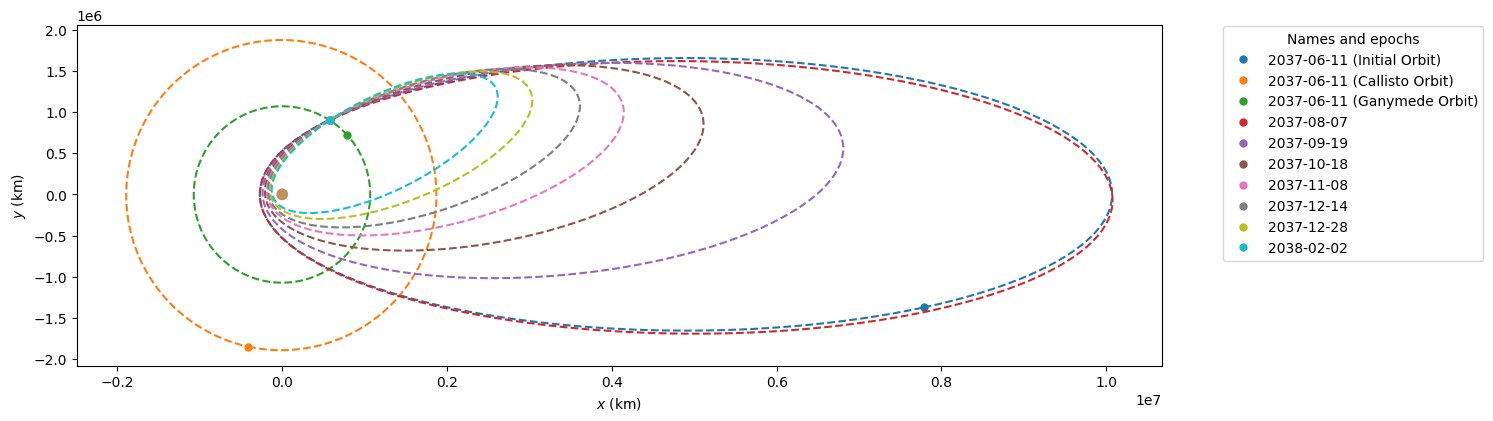

In [ ]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
# plotter.plot(starship_flyby_orbit)
plotter.plot(starship_orb,label="Initial Orbit")
plotter.plot(callisto_orb,label="Callisto Orbit")
plotter.plot(ganymede_orb,label="Ganymede Orbit")
print((orbits[-1].r_p.to(u.km)/Jupiter.R.to(u.km)).value)
for orbit in orbits:
    plotter.plot(orbit)   